In [1]:
import time
import datetime
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sbs

import pickle

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
version = 2

### Функция для анализа результатов

In [2]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nТочность {3:.3f} на обучающей выборке\n'
        'Точность {4:.3f} на тестовой выборке\n'
        'Потеря перекрестной энтропии {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """Корреляция для реальных и предсказываемых значений"""
    data = pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,0]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )
    return data, data.corr()

def plot_confusion_matrix(
    cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues
):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказываемое значение')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [3]:
def preprocess_v2(df, sc):
    df.drop(['Unnamed: 0'], inplace=True, axis=1)
    df.drop(df[df.exec_date == -1].index, inplace=True)
    df.loc[df['sup_okpd_exp'] > 1, 'sup_okpd_exp'] = 1
    
    for nv in num_var:
        df.loc[df[nv]==0, nv] = 1
        df[nv] = np.log(df[nv])
    
    nv01_columns_to_save = ['sup_okpd_exp', 'sup_sim_price']
    nv01_columns_to_drop = set(num_var01) - set(nv01_columns_to_save)
    df.drop(list(nv01_columns_to_drop), inplace=True, axis=1)
    
    columns_to_norm = num_var + nv01_columns_to_save
    data[columns_to_norm] = sc.transform(data[columns_to_norm])
    
    for nv in num_var:
        df['{}_rare'.format(nv)] = (np.abs(df[nv]) > 3) * 1
        df.loc[np.abs(df[nv]) > 3, nv] = 3
    
    df.drop(['sup_status'], inplace=True, axis=1)
    df.drop(cat_bin_var, inplace=True, axis=1)
    
    df.loc[df.sup_type == 0, 'sup_type'] = 3
    df.loc[(df.org_form == 45) | (df.org_form == 0), 'org_form'] = 13
    df.loc[(df.org_type == 1) | (df.org_type == -1), 'org_type'] = 12
    df.loc[df.type_prod == -1, 'type_prod'] = 19
    df.loc[df.cntr_lvl == -1, 'cntr_lvl'] = 3
    
    df['okpd_class'] = df['okpd'].apply(lambda a: pd.Series(a[:2]))
    df.drop(['okpd'], inplace=True, axis=1)
    
    cntr_start = df['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
    cntr_end = df['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
    df['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))
    df.drop(['sign_date', 'exec_date'], inplace=True, axis=1)

    df.drop(df[df.cntr_length == 0].index, inplace=True)
    
#     for column in ('sup_type', 'org_form', 'org_type', 'cntr_lvl', 'type_prod', 'okpd_class'):
#         dummies = pd.get_dummies(df[column], prefix=column[:6], drop_first=True)
#         df = pd.concat([df, dummies], axis=1)
#         df.drop([column], inplace=True, axis=1)
    
    X = df.drop(['cntrID', 'cntr_result'], axis=1).values
    y = df.cntr_result.values
    
    return X, y

In [4]:
def preprocess_v1(df, sc):
    column_names = [
       'org_cntr_num', 'org_1s_sev', 'org_1s_sup_sev',
       'sup_cntr_num', 'sup_cntr_avg_price', 'sup_cntr_avg_penalty',
       'sup_no_pnl_share', 'sup_okpd_exp', 'sup_1s_sev', 'sup_1s_org_sev',
       'sup_sim_price', 'sup_type', 'org_form', 'price_higher_pmp',
       'price_too_low', 'price', 'pmp', 'okpd', 'cntr_result'
    ]
    columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price']
    df = df[column_names]
    
    X = df.drop(['cntr_result'], axis=1)
    X.loc[:, columns_to_normalize] = sc.transform(X.loc[:, columns_to_normalize])

    X.loc[X['pmp']==0, 'pmp'] = 1
    X.loc[X['price']==0, 'price'] = 1
    X['pmp'] = np.log(X['pmp'])
    X['price'] = np.log(X['price'])
    
    X = X.values
    y = df.cntr_result.values
    
    return X, y

In [5]:
def test_model(df, clf, model_name, sc, version=2):
    
    if version == 1:
        X_test, y_test = preprocess_v1(df, sc)
    else:
        X_test, y_test = preprocess_v2(df, sc)
    
    
    y_test_pred = clf.predict(X_test)
    y_test_pred_proba = clf.predict_proba(X_test)
    
    print(classification_report(y_test, y_test_pred, target_names=('Плохой', 'Хороший')))
    print('Точность {:.3f}'.format(accuracy_score(y_test, y_test_pred)))
    print('Потеря {:.3f}'.format(log_loss(y_test[:len(y_test_pred_proba)], y_test_pred_proba)))
    
    plot_confusion_matrix(
        confusion_matrix(y_test, y_test_pred), 
        classes=clf.classes_,
        title=model_name
    )
    
    res, res_corr = real_and_predicted_correlation(y_test, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_dependence(res, title=model_name)

In [6]:
def learn_one_model(classifier, clf_name, kfold=10):
    """Функция для обучения одной модели"""
    
    start_time = time.time()

    y_train_real = np.array([])
    y_test_real = np.array([])
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0, 2))
    
    kfolds_generator = KFold(n_splits=kfold, shuffle=True, random_state=random_seed)
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X)):
        print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        classifier.fit(X_train, y_train)
    
        y_train_real = np.concatenate((y_train_real, y_train))
        y_test_real = np.concatenate((y_test_real, y_test))
        y_train_pred = np.concatenate((y_train_pred, classifier.predict(X_train)))
        y_test_pred = np.concatenate((y_test_pred, classifier.predict(X_test)))
        y_test_pred_proba = np.concatenate((y_test_pred_proba, classifier.predict_proba(X_test))) 
    print("Обучение заняло %s секунд\n" % (time.time() - start_time))
    print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba)
    res, res_corr = real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_confusion_matrix(
        confusion_matrix(y_test_real, y_test_pred), 
        classes=classifier.classes_, 
        title='Матрица ошибок'
    )
    plot_dependence(res)
    plot_roc_curve(y_test_real, y_test_pred)
    return classifier

In [7]:
def save_model(clf, clf_name, version=version):
    """Сохранение модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'wb') as file:
        pickle.dump(clf, file)
        
def save_scaler(scl, version=version):
    with open('model/skaler{}.pkl'.format(version), 'wb') as file:
        pickle.dump(scl, file)

def load_model(clf_name, version=version):
    """Загрузка модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'rb') as file:
        return pickle.load(file)
    
def load_scaler(version=version):
    with open('model/skaler{}.pkl'.format(version), 'rb') as file:
        return pickle.load(file)

### Считывание данных

In [8]:
data = pd.read_csv('../data/2/tula_yarobl_finished.csv', converters={'okpd': str})
print(data.shape)
data.head(5)

(37997, 27)


,Unnamed: 0,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,...,price_higher_pmp,price_too_low,price,pmp,okpd,type_prod,cntr_lvl,sign_date,exec_date,cntr_result
0,0,480853,177,0.0,0.0,292,51386,0.0,1.0,1.0,...,0,0,15985.44,15985.44,0,19,3,20150112,20150331,0
1,1,480867,431,0.0,0.0,6,171863,0.0,1.0,1.0,...,0,0,98355.00,98850.00,0,19,3,20150110,20151231,0
2,2,481366,621,0.0,0.0,287,215299,0.0,1.0,1.0,...,0,0,82724.30,83140.00,0,19,2,20150112,20151231,0
3,3,481425,773,0.0,0.0,1,90000,0.0,1.0,1.0,...,0,0,90000.00,90000.00,0,19,2,20150112,20151231,0
4,4,481812,76,0.0,0.0,365,201042,0.0,1.0,1.0,...,0,0,107440.10,107980.00,0,19,2,20150114,20150430,0


In [9]:
# Удаление столбца
data.drop(['Unnamed: 0'], inplace=True, axis=1)

# Удаление строк с датой окончания контракта равной -1
data.drop(data[data.exec_date == -1].index, inplace=True)

# Исправление ошибки на уровне сбора данных
data.loc[data['sup_okpd_exp'] > 1, 'sup_okpd_exp'] = 1

In [10]:
num_var = [
    'org_cntr_num', 'sup_cntr_num', 
    'sup_cntr_avg_price', 
    'price', 'pmp'
]
num_var01 = [
    'org_1s_sev', 'org_1s_sup_sev', 'sup_cntr_avg_penalty',
    'sup_no_pnl_share', 'sup_okpd_exp', 
    'sup_1s_sev', 'sup_1s_org_sev',
    'sup_sim_price'
]
cat_var = [
    'sup_type', 'sup_status', 'org_form', 'org_type',
    'okpd', 'type_prod', 'cntr_lvl'
]
cat_bin_var = [
    'price_higher_pmp', 'price_too_low'
]

### Предобработка

#### Обработка количественных переменных
1. Логарифмирование всех переменных, так как они имеют большие правые хвосты
2. Нормирование
3. Удаление выбросов (сохраняем все, что внутри интервала [-3sig, 3sig]

#### Обработка количественных переменных в диапозоне [0, 1]
1. Удалить все переменные кроме sup_okpd_exp и sup_sim_price
2. Нормировать

#### Обработка категориальных переменных
1. Удалить переменную sup_status
2. sup_type -> 0 = 3
3. org_form -> 45 = 13; 0 = 13
4. org_type -> 1 = 12; -1 = 12
5. type_prod -> -1 = 19
6. cntr_lvl -> -1 = 3

#### Обработка категориальных бинарных переменных
1. Удалить обе переменные

In [11]:
# Логарифмирование количественных переменных
for nv in num_var:
    data.loc[data[nv]==0, nv] = 1
    data[nv] = np.log(data[nv])

In [12]:
# Удаление неинформативных переменных
nv01_columns_to_save = ['sup_okpd_exp', 'sup_sim_price']
nv01_columns_to_drop = set(num_var01) - set(nv01_columns_to_save)
data.drop(list(nv01_columns_to_drop), inplace=True, axis=1)

In [13]:
# Нормализация
scaler = StandardScaler()
columns_to_norm = num_var + nv01_columns_to_save
data[columns_to_norm] = scaler.fit_transform(data[columns_to_norm])
save_scaler(scaler)

In [14]:
# Обработка выбросов 
# Значения большие по модулю 3*std приравниваются к 3*std
# Для таких значений создается дополнительный столбец, где 1 соответствует бывшему выбросу
for nv in num_var:
    data['{}_rare'.format(nv)] = (np.abs(data[nv]) > 3) * 1
    data.loc[np.abs(data[nv]) > 3, nv] = 3
print(data.shape)

(37995, 25)


In [15]:
data.drop(['sup_status'], inplace=True, axis=1)
data.drop(cat_bin_var, inplace=True, axis=1)

In [16]:
data.loc[data.sup_type == 0, 'sup_type'] = 3
data.loc[(data.org_form == 45) | (data.org_form == 0), 'org_form'] = 13
data.loc[(data.org_type == 1) | (data.org_type == -1), 'org_type'] = 12
data.loc[data.type_prod == -1, 'type_prod'] = 19
data.loc[data.cntr_lvl == -1, 'cntr_lvl'] = 3

In [17]:
data[columns_to_norm].describe()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp,sup_okpd_exp,sup_sim_price
count,37995.000000,3.799500e+04,37995.000000,37995.000000,37995.000000,3.799500e+04,3.799500e+04
mean,0.024267,-1.699977e-14,0.001913,0.011503,0.187315,1.053089e-14,-4.052717e-15
std,0.992396,1.000013e+00,0.949109,0.989625,0.819987,1.000013e+00,1.000013e+00
min,-2.907273,-1.640486e+00,-2.978667,-2.995530,-2.878572,-1.327459e+00,-7.827156e-01
25%,-0.635440,-8.523409e-01,-0.606813,-0.634241,-0.317682,-1.195215e+00,-5.500448e-01
50%,-0.025857,3.574814e-02,-0.132152,-0.026820,0.108175,3.587359e-01,-4.096016e-01
75%,0.827324,1.109923e+00,0.496403,0.653162,0.598347,9.983270e-01,-6.612093e-02
max,3.000000,1.298782e+00,3.000000,3.000000,3.000000,9.983270e-01,2.720045e+00


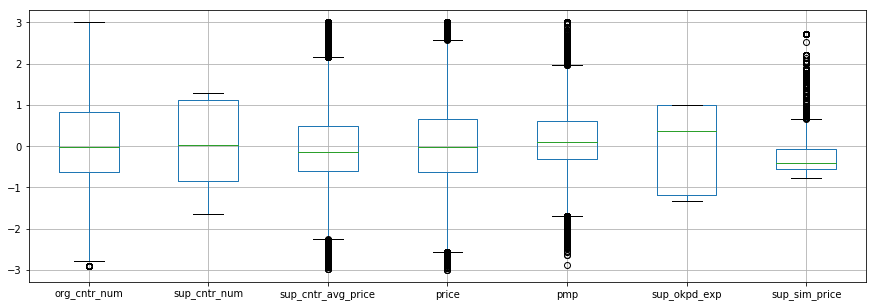

In [18]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
data[columns_to_norm].boxplot(ax=ax)

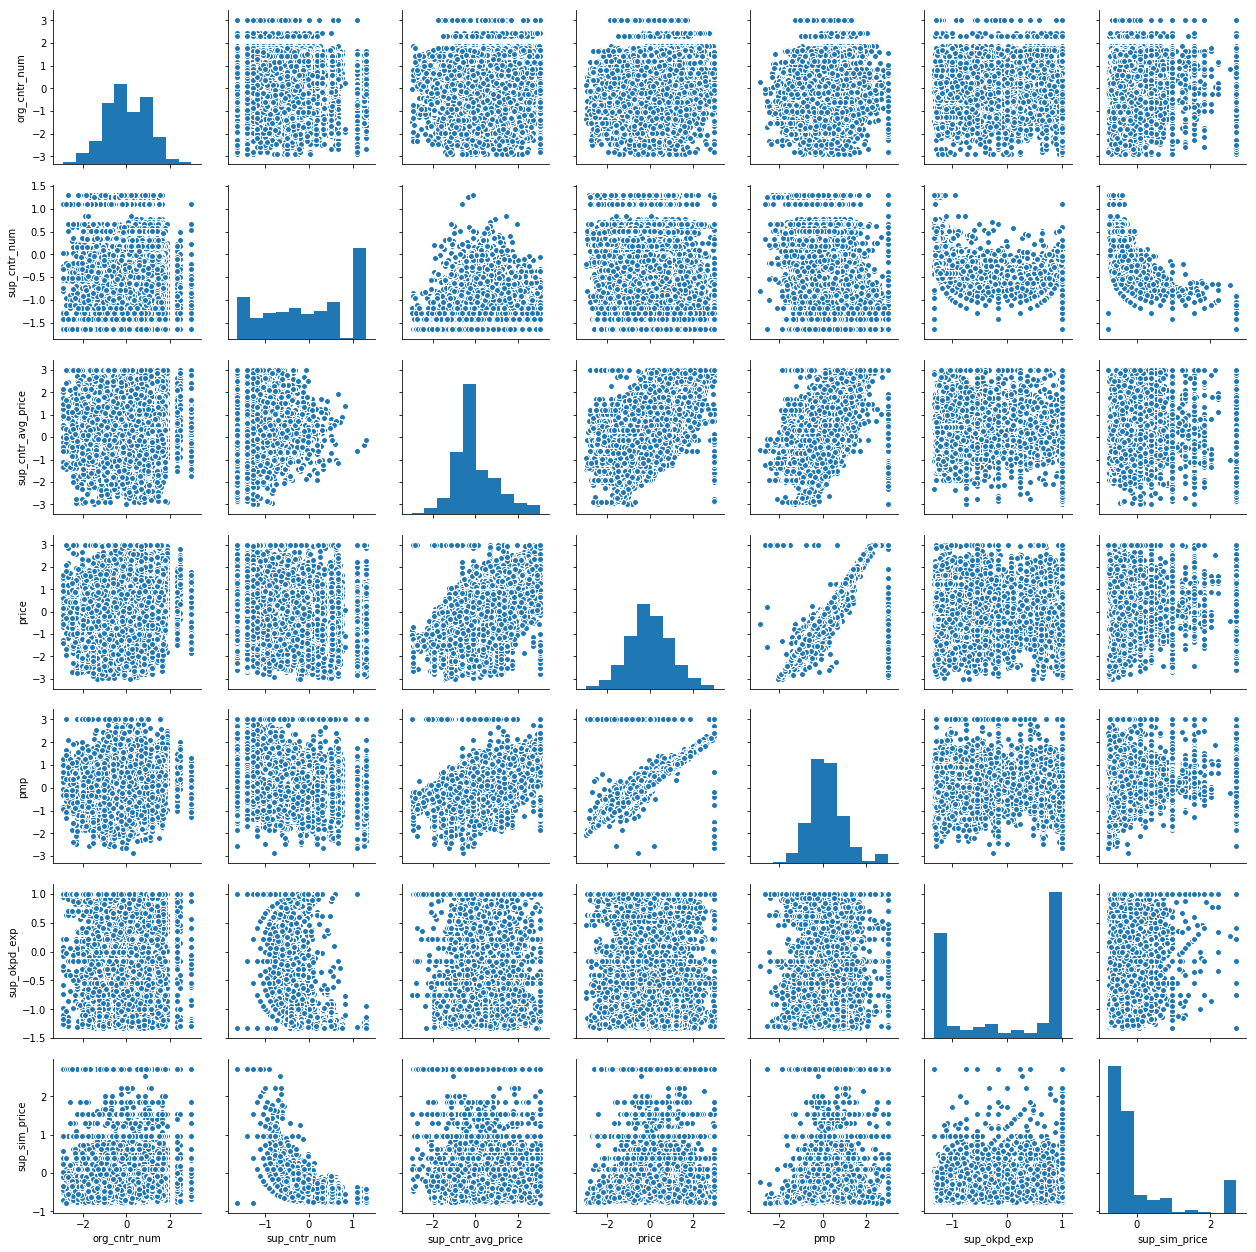

In [19]:
sbs.pairplot(data[columns_to_norm])

### Feature Engineering

1. Производная переменная, учитывающая только класс от ОКПД 
2. Переменную, определяющая длину контракта с последующим удалением sign_date, exec_date)
3. PMP и Price имеют высокую корреляцию, а также price и sup_cntr_avg_price. Необходимо какие-то из переменных исключить.

In [20]:
data['okpd_class'] = data['okpd'].apply(lambda a: pd.Series(a[:2]))
data.drop(['okpd'], inplace=True, axis=1)

In [21]:
cntr_start = data['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
cntr_end = data['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
data['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))
data.drop(['sign_date', 'exec_date'], inplace=True, axis=1)

# Удаление контрактов длиной в 0 дней
data.drop(data[data.cntr_length == 0].index, inplace=True)

In [22]:
# for column in ('sup_type', 'org_form', 'org_type', 'cntr_lvl', 'type_prod', 'okpd_class'):
#     dummies = pd.get_dummies(data[column], prefix=column[:6], drop_first=True)
#     data = pd.concat([data, dummies], axis=1)
#     data.drop([column], inplace=True, axis=1)

In [23]:
print(data.shape)
data.head()

(37830, 21)


,cntrID,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,sup_okpd_exp,sup_sim_price,sup_type,org_form,org_type,price,...,type_prod,cntr_lvl,cntr_result,org_cntr_num_rare,sup_cntr_num_rare,sup_cntr_avg_price_rare,price_rare,pmp_rare,okpd_class,cntr_length
0,480853,-0.303711,0.225361,-1.069622,0.998327,-0.410863,3,13,11,-1.058634,...,19,3,0,0,0,0,0,0,0,78
1,480867,0.380921,-1.051567,0.023394,0.998327,-0.198911,3,13,41,-0.029954,...,19,3,0,0,0,0,0,0,0,355
2,481366,0.661882,0.219684,0.227389,0.998327,-0.514194,3,13,12,-0.127941,...,19,2,0,0,0,0,0,0,0,353
3,481425,0.830315,-1.640486,-0.562244,0.998327,2.720045,1,8,41,-0.080215,...,19,2,0,0,0,0,0,0,0,353
4,481812,-0.954077,0.298704,0.165362,0.998327,-0.418043,3,13,11,0.020067,...,19,2,0,0,0,0,0,0,0,106


In [25]:
X = data.drop(['cntrID', 'cntr_result'], axis=1).values
y = data.cntr_result.values

In [26]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
save_model(xgb, 'xgb')

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

print('Acc: {}, Log_loss: {}'.format(accuracy_score(y_test, y_pred), log_loss(y_test, y_pred_proba)))

Acc: 0.921887390959556, Log_loss: 0.21169949415420705
CPU times: user 1.63 s, sys: 17 ms, total: 1.65 s
Wall time: 1.65 s


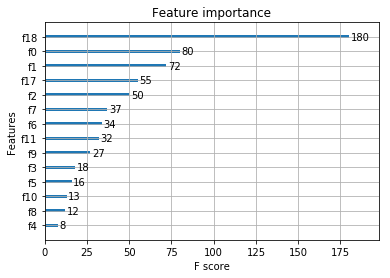

In [27]:
plot_importance(xgb)

In [28]:
federal_lvl_data = pd.read_csv('../data/2/tula_yarobl_grbs_finished.csv', converters={'okpd': str})
federal_lvl_data.head()

,Unnamed: 0,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,...,price_higher_pmp,price_too_low,price,pmp,okpd,type_prod,cntr_lvl,sign_date,exec_date,cntr_result
0,0,1505399,141,0.0,0.0,1,262800,0.0,1.0,1.0,...,0,0,262800.00,265230.9,0,-1,1,20150101,20151231,1
1,1,1505542,164,0.0,0.0,2,336037,0.0,1.0,1.0,...,0,0,433100.00,714000.0,0,-1,1,20150112,20151231,1
2,2,1505554,581,0.0,0.0,2,198450,0.0,1.0,1.0,...,0,0,152100.00,152100.0,0,-1,1,20150112,20150131,1
3,3,1505963,2157,0.0,0.0,4,269765,0.0,1.0,0.5,...,0,0,50000.00,50000.0,0,-1,1,20150112,20150126,1
4,4,1505984,598,0.0,0.0,8,521224,0.0,1.0,1.0,...,0,0,998007.17,1013361.0,0,-1,1,20150112,20151231,1


             precision    recall  f1-score   support

     Плохой       0.02      0.72      0.04       575
    Хороший       0.98      0.27      0.42     24283

avg / total       0.95      0.28      0.41     24858

Точность 0.279
Потеря 3.559


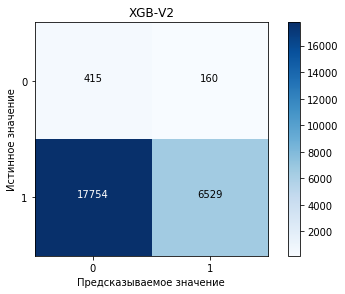

              result  proba_pred      pred
result      1.000000    0.001976 -0.003183
proba_pred  0.001976    1.000000 -0.994249
pred       -0.003183   -0.994249  1.000000


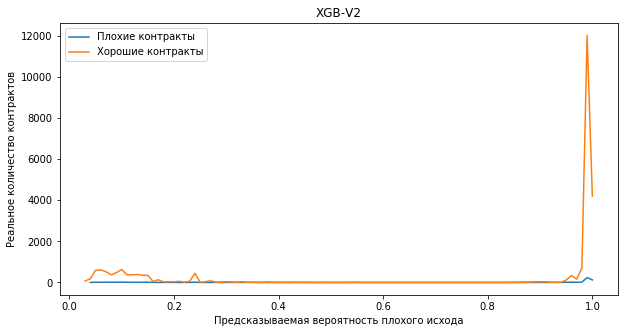

In [29]:
test_model(
    federal_lvl_data.copy(), 
    xgb, 
    'XGB-V2', 
    load_scaler(version=2), 
    version=2)

             precision    recall  f1-score   support

     Плохой       0.02      0.97      0.04       575
    Хороший       0.97      0.03      0.05     24337

avg / total       0.95      0.05      0.05     24912

Точность 0.048
Потеря 4.681


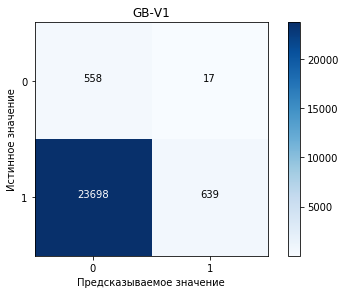

              result  proba_pred      pred
result      1.000000   -0.004123 -0.003103
proba_pred -0.004123    1.000000 -0.896452
pred       -0.003103   -0.896452  1.000000


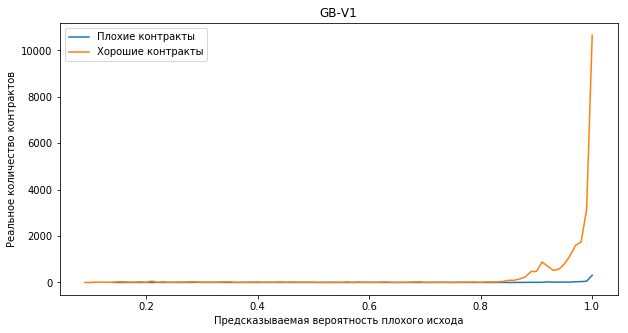

In [30]:
test_model(
    federal_lvl_data.copy(), 
    load_model('gb', version=1), 
    'GB-V1', 
    load_scaler(version=1), 
    version=1)